In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})

In [4]:
VC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
MC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})

In [5]:
ctrl = ctrl_sst.sst.compute()

In [6]:
OC = OC.sst.compute()

In [7]:
MC = MC.sst.compute()

In [8]:
VC = VC.sst.compute()

In [9]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.xt_ocean)
    
    return df

In [10]:
ctrl = roll_longitude(ctrl)
MC = roll_longitude(MC)
VC = roll_longitude(VC)
OC = roll_longitude(OC)

In [11]:
ctrl = ctrl.sel(time = slice("0952-01-01", "1150-12-31"))
MC = MC.sel(time = slice("0952-01-01", "1100-12-31"))
OC = OC.sel(time = slice("0952-01-01", "1020-12-31"))
VC = VC.sel(time = slice("0952-01-01", "1020-12-31"))

In [12]:
len(OC)/12

69.0

In [14]:
def ssta_exp(DS):
    clim = ctrl.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def dmi_exp(DS):
    WTIO = ssta_exp(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = ssta_exp(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return  WTIO-SETIO

In [13]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def dmi(DS):
    WTIO = ssta(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = ssta(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return  WTIO-SETIO

In [15]:
def percentiles_index(index, da1):
    #Step 0 get the index of the control. 
    da = index(ctrl)
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select years base don lenght of TS with replacement
        length = int(len(da1)/12)
        random_years = np.random.choice(da['time.year'], size=length, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    return percentiles-da.groupby("time.month").std("time")

In [16]:
OC_p = percentiles_index(dmi_exp, OC)
MC_p = percentiles_index(dmi_exp, MC)
VC_p = percentiles_index(dmi_exp, VC)

In [17]:
OC_p

<xarray.DataArray 'sst' (quantile: 2, month: 12)>
array([[-0.06171728, -0.04083298, -0.03358139, -0.02611669, -0.02590343,
        -0.04876528, -0.05000315, -0.07152403, -0.0798261 , -0.078192  ,
        -0.068315  , -0.07137791],
       [ 0.05462822,  0.03442566,  0.03385681,  0.02292138,  0.02021693,
         0.04393635,  0.04313753,  0.05687285,  0.06829148,  0.06332054,
         0.05880897,  0.0588492 ]])
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantile  (quantile) float64 0.05 0.95

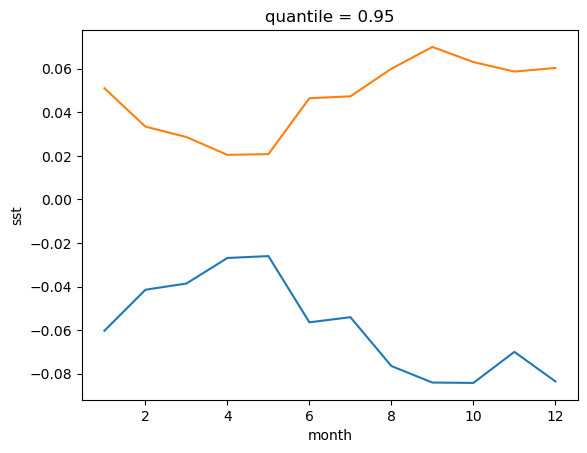

In [18]:
(VC_p)[0].plot()
(VC_p)[1].plot()

In [19]:
OC_dmi = dmi_exp(OC).groupby("time.month").std("time")
MC_dmi = dmi_exp(MC).groupby("time.month").std("time")
VC_dmi = dmi_exp(VC).groupby("time.month").std("time")
ctrl_dmi = dmi_exp(ctrl).groupby("time.month").std("time")

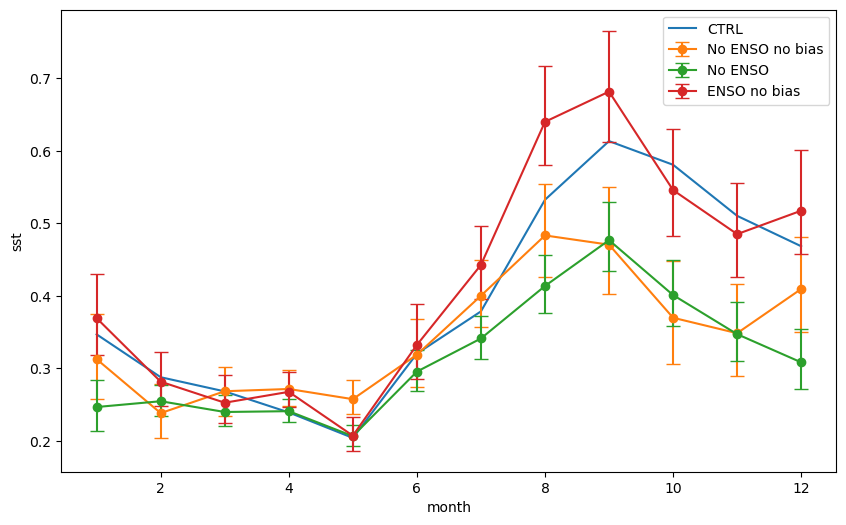

In [20]:
plt.figure(figsize = (10,6))
ctrl_dmi.plot(label = "CTRL")
plt.errorbar(OC_dmi.month, OC_dmi, yerr=[abs(OC_p[1]), abs(OC_p[0])]
                 , fmt='-o', capsize=5, label = 'No ENSO no bias')
plt.errorbar(MC_dmi.month, MC_dmi, yerr=[abs(MC_p[1]), abs(MC_p[0])]
                 , fmt='-o', capsize=5, label = 'No ENSO')
plt.errorbar(VC_dmi.month, VC_dmi, yerr=[abs(VC_p[1]), abs(VC_p[0])]
                 , fmt='-o', capsize=5, label = 'ENSO no bias')
plt.legend()